# Step 1: Import Libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras.applications import VGG16, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# Step 2: Define Functions for Loading Images

In [2]:
# Define a mapping of folder names to class names
class_mapping = {
    'Malignant cases': 0,
    'Bengin cases': 1,
    'Normal cases': 2
}

# Reverse mapping to convert numerical labels back to class names
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Function to convert numerical labels back to class names
def numerical_to_classname(label):
    return reverse_class_mapping[label]

# Function to load images from folder
def load_images_from_folder(folder, img_width=224, img_height=224):
    images = []
    labels = []
    class_name = class_mapping.get(os.path.basename(folder), -1)
    for filename in os.listdir(folder):
        img = image.load_img(os.path.join(folder, filename), target_size=(img_width, img_height))
        img = image.img_to_array(img)
        images.append(img)
        labels.append(class_name)
    return np.array(images), np.array(labels)

# Step 3: Load and Preparing Images

In [3]:
# Load images and labels, and get class name
def load_dataset(dataset_path):
    images = []
    labels = []
    class_names = []
    for subdir in os.listdir(dataset_path):
        subdir_path = os.path.join(dataset_path, subdir)
        if os.path.isdir(subdir_path):
            img_data, img_labels = load_images_from_folder(subdir_path)
            images.extend(img_data)
            labels.extend(img_labels)
            class_names.append(class_mapping.get(subdir, 'Unknown'))
    return np.array(images), np.array(labels), class_names

# Load images and making labels
dataset_path = './dataset' # Dataset root path
images, labels, class_names = load_dataset(dataset_path)

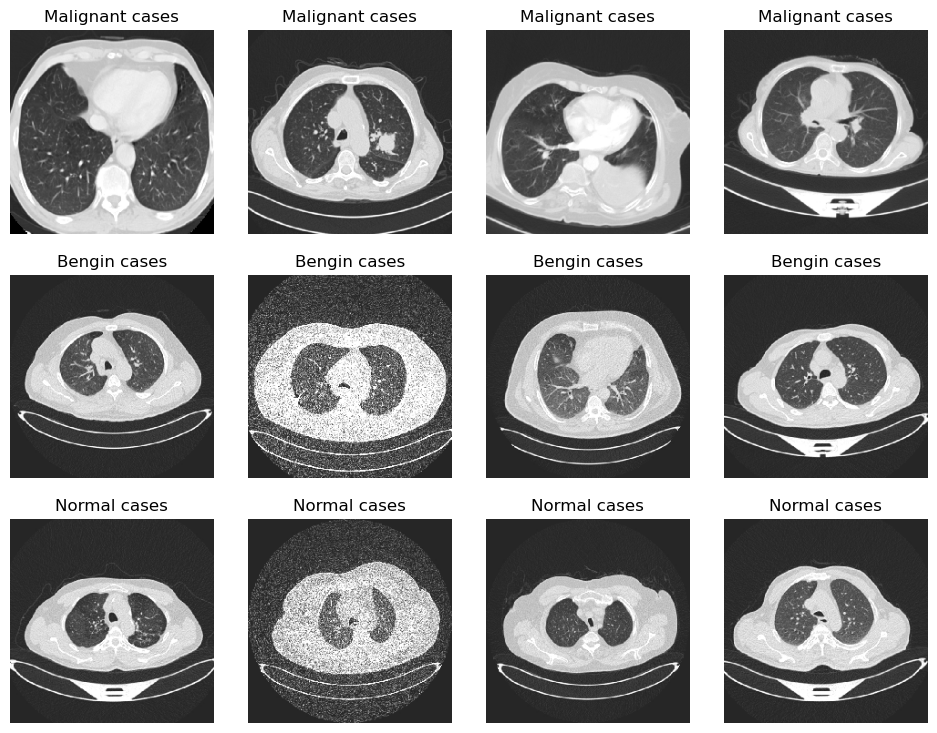

In [4]:
def show_sample_images(images, labels, class_names):
    unique_classes = np.unique(labels)
    num_classes = len(unique_classes)
    fig, axes = plt.subplots(num_classes, 4, figsize=(12, 3*num_classes))  # Adjust the figsize

    for i, class_name in enumerate(unique_classes):
        class_images = images[labels == class_name]
        for j in range(4):
            axes[i, j].imshow(class_images[j].astype('uint8'))
            axes[i, j].set_title(numerical_to_classname(class_name))
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust the spacing between subplots
    plt.show()

# Usage
show_sample_images(images, labels, class_names)

# Step 4: Define CNN Model Creation Function

In [5]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    # Create a Sequential model
    model = Sequential()

    # Add the first convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Add the second convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Add the third convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # Add max pooling layer to downsample the feature maps
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output from convolutional layers to a 1D array
    model.add(Flatten())

    # Add a fully connected dense layer with 128 units and ReLU activation
    model.add(Dense(128, activation='relu'))
    # Apply dropout regularization to prevent overfitting
    model.add(Dropout(0.5))

    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Step 5: Define Transfer Learning Models Using VGG16 Functions

In [6]:
# Function to create transfer learning model using VGG16
def create_vgg_model(input_shape=(224, 224, 3), num_classes=3):
    # Load pre-trained VGG16 model with weights from ImageNet
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Set all layers in VGG16 model to non-trainable
    for layer in vgg_model.layers:
        layer.trainable = False
    
    # Create a Sequential model
    model = Sequential()
    
    # Add the pre-trained VGG16 model to the Sequential model
    model.add(vgg_model)
    
    # Flatten the output from VGG16 model
    model.add(Flatten())
    
    # Add a fully connected dense layer with 256 units and ReLU activation
    model.add(Dense(256, activation='relu'))
    
    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Step 6: Define Transfer Learning Models Using ResNet50 Functions

In [7]:
# Function to create transfer learning model using ResNet50
def create_resnet_model(input_shape=(224, 224, 3), num_classes=3):
    # Load pre-trained ResNet50 model with weights from ImageNet
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Set all layers in ResNet50 model to non-trainable
    for layer in resnet_model.layers:
        layer.trainable = False
    
    # Create a Sequential model
    model = Sequential()
    
    # Add the pre-trained ResNet50 model to the Sequential model
    model.add(resnet_model)
    
    # Flatten the output from ResNet50 model
    model.add(Flatten())
    
    # Add a fully connected dense layer with 256 units and ReLU activation
    model.add(Dense(256, activation='relu'))
    
    # Add the output layer with softmax activation for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Step 7: Define Model Training Function

In [16]:
# Function to load data and train model
def train_model(data, model_creator, model_name='', img_width=224, img_height=224, num_epochs=10, batch_size=32):
    images = data['images']
    labels = data['labels']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10, shuffle=True)

    # Create model
    model = model_creator(input_shape=(img_width, img_height, 3))

    # Train model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    # Plot graph
    plot_accuracy_loss_side_by_side(history, model_name)

    return model, history

# Step 8: Show Plot Accuracy and Loss Graphs

In [39]:
# Function to plot accuracy and loss graphs side by side
def plot_accuracy_loss_side_by_side(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.legend()

    plt.show()
    
# Plot graph for Random Forest
def plot_accuracy_rf(train_accuracy, test_accuracy):
    plt.figure(figsize=(8, 6))
    plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.title('Random Forest - Train and Test Accuracy')
    plt.show()

# Step 9: Define Function for Training Random Forest Model

In [13]:
# Function to train Random Forest model
def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    return rf

# Step 10: Main Code Execution

Epoch 1/10
28/28 [==============================] - 10s 341ms/step - loss: 53.2985 - accuracy: 0.5827 - val_loss: 0.4210 - val_accuracy: 0.8545
Epoch 2/10
28/28 [==============================] - 10s 341ms/step - loss: 0.4705 - accuracy: 0.8415 - val_loss: 0.1769 - val_accuracy: 0.9500
Epoch 3/10
28/28 [==============================] - 10s 343ms/step - loss: 0.2854 - accuracy: 0.8997 - val_loss: 0.1318 - val_accuracy: 0.9545
Epoch 4/10
28/28 [==============================] - 10s 340ms/step - loss: 0.1638 - accuracy: 0.9475 - val_loss: 0.0741 - val_accuracy: 0.9773
Epoch 5/10
28/28 [==============================] - 10s 341ms/step - loss: 0.0883 - accuracy: 0.9715 - val_loss: 0.0564 - val_accuracy: 0.9727
Epoch 6/10
28/28 [==============================] - 10s 344ms/step - loss: 0.0866 - accuracy: 0.9783 - val_loss: 0.0341 - val_accuracy: 0.9818
Epoch 7/10
28/28 [==============================] - 10s 341ms/step - loss: 0.0480 - accuracy: 0.9829 - val_loss: 0.0343 - val_accuracy: 0.977

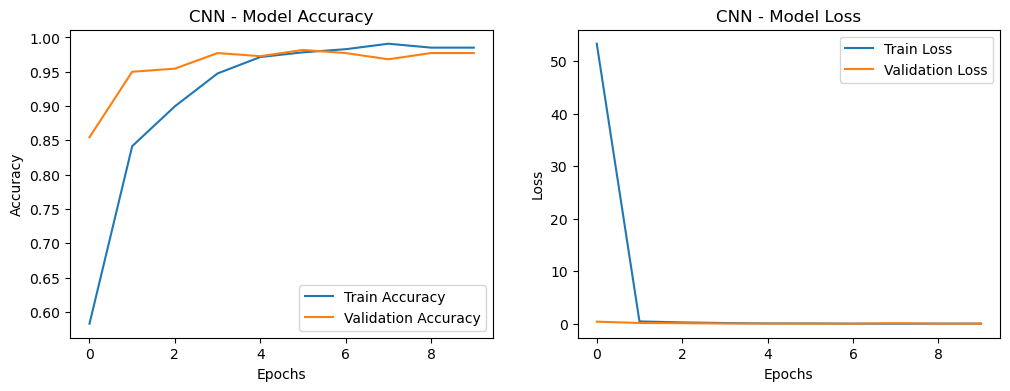

/opt/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Train CNN model and get its history
cnn_model, cnn_history = train_model(
    {'images': images, 'labels': labels},
    create_cnn_model,
    'CNN'
)

# Save CNN model
cnn_model.save('./models/cnn_model.h5')

Epoch 1/10
28/28 [==============================] - 63s 2s/step - loss: 3.3567 - accuracy: 0.8073 - val_loss: 0.4282 - val_accuracy: 0.9500
Epoch 2/10
28/28 [==============================] - 63s 2s/step - loss: 0.1703 - accuracy: 0.9761 - val_loss: 0.2975 - val_accuracy: 0.9591
Epoch 3/10
28/28 [==============================] - 66s 2s/step - loss: 0.0460 - accuracy: 0.9909 - val_loss: 0.2565 - val_accuracy: 0.9682
Epoch 4/10
28/28 [==============================] - 65s 2s/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.3065 - val_accuracy: 0.9636
Epoch 5/10
28/28 [==============================] - 65s 2s/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 0.3263 - val_accuracy: 0.9636
Epoch 6/10
28/28 [==============================] - 64s 2s/step - loss: 0.0200 - accuracy: 0.9977 - val_loss: 0.4031 - val_accuracy: 0.9636
Epoch 7/10
28/28 [==============================] - 64s 2s/step - loss: 0.0080 - accuracy: 0.9954 - val_loss: 0.2501 - val_accuracy: 0.9636
Epoch 8/10
28/28 [==

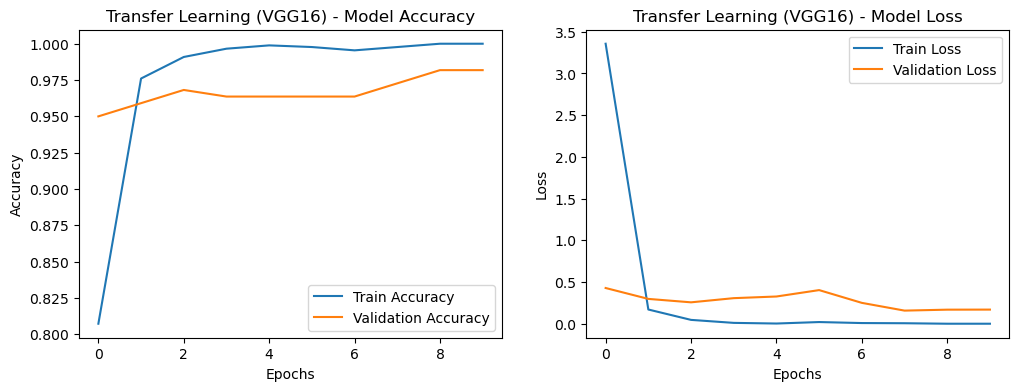

In [18]:
# Train Transfer Learning (VGG16) model and get its history
vgg_model, vgg_history = train_model(
    {'images': images, 'labels': labels},
    create_vgg_model,
    'Transfer Learning (VGG16)',
    img_width = 224,
    img_height = 224
)

# Save Transfer Learning (VGG16) model
vgg_model.save('./models/vgg_model.h5')

Epoch 1/10
28/28 [==============================] - 23s 771ms/step - loss: 2.0245 - accuracy: 0.8255 - val_loss: 0.2931 - val_accuracy: 0.9273
Epoch 2/10
28/28 [==============================] - 21s 740ms/step - loss: 0.0650 - accuracy: 0.9795 - val_loss: 0.1692 - val_accuracy: 0.9591
Epoch 3/10
28/28 [==============================] - 20s 724ms/step - loss: 0.0221 - accuracy: 0.9977 - val_loss: 0.1187 - val_accuracy: 0.9773
Epoch 4/10
28/28 [==============================] - 20s 726ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.1009 - val_accuracy: 0.9818
Epoch 5/10
28/28 [==============================] - 21s 737ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.1186 - val_accuracy: 0.9773
Epoch 6/10
28/28 [==============================] - 20s 729ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.0970 - val_accuracy: 0.9773
Epoch 7/10
28/28 [==============================] - 20s 728ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0925 - val_accuracy: 0.9864

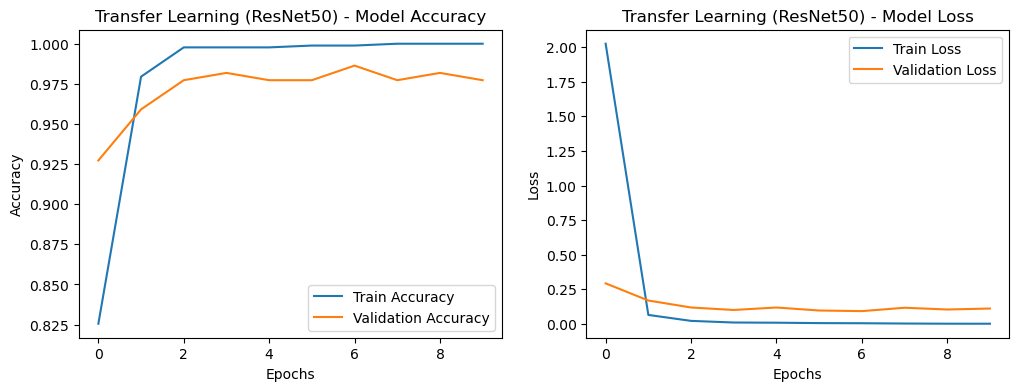

In [19]:
# Train Transfer Learning (ResNet50) model and get its history
resnet_model, resnet_history = train_model(
    {'images': images, 'labels': labels},
    create_resnet_model,
    'Transfer Learning (ResNet50)',
    img_width = 224,
    img_height = 224
)

# Save Transfer Learning (ResNet50) model
resnet_model.save('./models/resnet_model.h5')

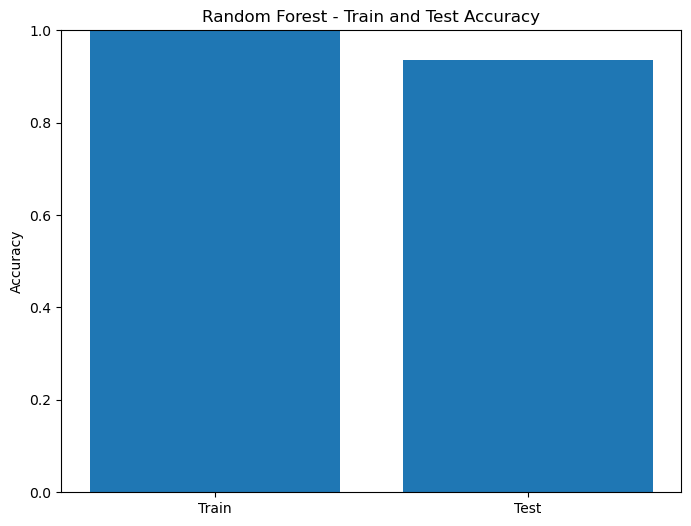

['./models/rf_model.joblib']

In [40]:
# Train Random Forest model
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
rf_model = train_random_forest(
    X_train,
    y_train
)

# Evaluate Random Forest model
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate train accuracy for RF
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train.reshape(X_train.shape[0], -1)))

# Calculate test accuracy for RF
rf_test_accuracy = accuracy_score(y_test, rf_predictions)

# Plot train and test accuracies side by side for RF
plot_accuracy_rf(rf_train_accuracy, rf_test_accuracy)

# Save Random Forest model
joblib.dump(rf_model, './models/rf_model.joblib')

In [21]:
# Create a table for comparison
import pandas as pd
models_data = {
    'Model': ['CNN', 'Transfer Learning (VGG16)', 'Transfer Learning (ResNet50)', 'Random Forest'],
    'Accuracy': [cnn_history.history['val_accuracy'][-1], vgg_history.history['val_accuracy'][-1], resnet_history.history['val_accuracy'][-1], rf_test_accuracy],
}
df = pd.DataFrame(models_data)

# Find index of highest accuracy
max_index = df['Accuracy'].idxmax()

# Highlight highest accuracy
styled_df = df.style.highlight_max(subset=['Accuracy'], color='lightgreen', axis=0)

# Display styled DataFrame
styled_df

,Model,Accuracy
0,CNN,0.977273
1,Transfer Learning (VGG16),0.981818
2,Transfer Learning (ResNet50),0.977273
3,Random Forest,0.936364


# Step 11: Define Function for Predicting on Sample Image

In [34]:
def predict_class_from_sample_image(sample_image_path, cnn_model, transfer_learning_model, resnet_model, rf_model):
    # Load and preprocess the sample image
    img = image.load_img(sample_image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Predict using CNN model
    cnn_prediction = cnn_model.predict(img)
    cnn_class = np.argmax(cnn_prediction)
    cnn_accuracy = cnn_prediction[0][cnn_class]  # Probability of the predicted class

    # Predict using Transfer Learning (VGG16) model
    vgg_prediction = transfer_learning_model.predict(img)
    vgg_class = np.argmax(vgg_prediction)
    vgg_accuracy = vgg_prediction[0][vgg_class]  # Probability of the predicted class

    # Predict using Transfer Learning (ResNet50) model
    resnet_prediction = resnet_model.predict(img)
    resnet_class = np.argmax(resnet_prediction)
    resnet_accuracy = resnet_prediction[0][resnet_class]  # Probability of the predicted class

    # Predict using Random Forest model
    rf_prediction = rf_model.predict(img.reshape(1, -1))
    rf_class = rf_prediction[0]
    rf_accuracy = max(rf_model.predict_proba(img.reshape(1, -1))[0])  # Maximum probability across all classes

    # Return predictions with accuracy scores
    return {
        'CNN': {'class': numerical_to_classname(cnn_class), 'accuracy': cnn_accuracy},
        'Transfer Learning (VGG16)': {'class': numerical_to_classname(vgg_class), 'accuracy': vgg_accuracy},
        'Transfer Learning (ResNet50)': {'class': numerical_to_classname(resnet_class), 'accuracy': resnet_accuracy},
        'Random Forest': {'class': numerical_to_classname(rf_class), 'accuracy': rf_accuracy}
    }

In [38]:
# Load the models
cnn_model = tf.keras.models.load_model('./models/cnn_model.h5')
vgg_model = tf.keras.models.load_model('./models/vgg_model.h5')
resnet_model = tf.keras.models.load_model('./models/resnet_model.h5')
rf_model = joblib.load('./models/rf_model.joblib')


sample_image_path = './dataset/Malignant cases/Malignant case (100).jpg'
predictions = predict_class_from_sample_image(sample_image_path, cnn_model, vgg_model, resnet_model, rf_model)

# Create a DataFrame from the dictionary
result = pd.DataFrame([(model, result['class'], result['accuracy']) for model, result in predictions.items()], columns=['Model', 'Predicred Class', 'Accuracy'])
result

1/1 [==============================] - 0s 405ms/step


,Model,Predicred Class,Accuracy
0,CNN,Malignant cases,0.999997
1,Transfer Learning (VGG16),Malignant cases,1.000000
2,Transfer Learning (ResNet50),Malignant cases,0.999999
3,Random Forest,Malignant cases,0.910000


In [41]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.15.0
TensorFlow version: 2.15.0
